In [1]:
## Load data

import xlsxwriter
import pandas as pd
from pandas import DataFrame

xlsx = pd.ExcelFile('/home/zan/Desktop/dl_autoencoder/docs/Deceptive-opinion.xlsx')
print(xlsx.sheet_names)

df = xlsx.parse('Hoja1')
print(df)

['Hoja1']
      deceptive             hotel  polarity       source  \
0      truthful            conrad  positive  TripAdvisor   
1      truthful             hyatt  positive  TripAdvisor   
2      truthful             hyatt  positive  TripAdvisor   
3      truthful              omni  positive  TripAdvisor   
4      truthful             hyatt  positive  TripAdvisor   
...         ...               ...       ...          ...   
1595  deceptive  intercontinental  negative        MTurk   
1596  deceptive            amalfi  negative        MTurk   
1597  deceptive  intercontinental  negative        MTurk   
1598  deceptive            palmer  negative        MTurk   
1599  deceptive            amalfi  negative        MTurk   

                                                   text  
0     We stayed for a one night getaway with family ...  
1     Triple A rate with upgrade to view room was le...  
2     This comes a little late as I'm finally catchi...  
3     The Omni Chicago really deliver

In [2]:
df.head(5)

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


(array([0, 1, 2]),
 [Text(0, 0, 'TripAdvisor'), Text(1, 0, 'MTurk'), Text(2, 0, 'Web')])

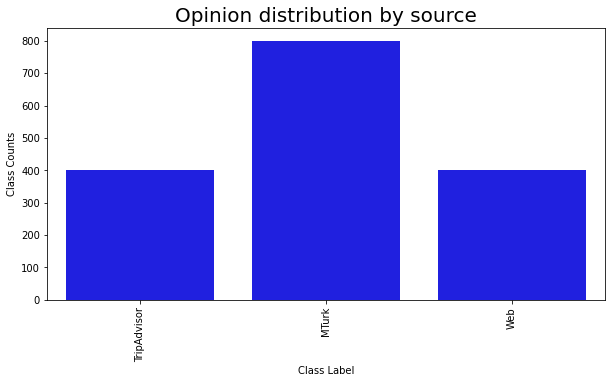

In [3]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x=df.source, color='blue')
plt.title('Opinion distribution by source', fontsize=20)
plt.ylabel('Class Counts', fontsize=10)
plt.xlabel('Class Label', fontsize=10)
plt.xticks(rotation='vertical')

In [ ]:
count_occurences = df['hotel'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(count_occurences.index, count_occurences.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df = df.drop(df.columns[[1, 2, 3]], axis = 1)

In [ ]:
df.head(5)

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=df.deceptive, color='red')
plt.title('Deceptive opinions', fontsize=20)
plt.ylabel('Class Counts', fontsize=10)
plt.xlabel('Class Label', fontsize=10)
plt.xticks(rotation='vertical')

In [ ]:
print(len(df[df['deceptive'] == 'truthful']))
print(len(df[df['deceptive'] == 'deceptive']))

In [ ]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [ ]:
texts = ''
for index, item in df.iterrows():
    texts += ' ' + item['text']
    
plot_word_cloud(texts)

In [ ]:
## sort values

df = df.sort_values(by=['deceptive'],ascending=False)

df['deceptive'].replace({"truthful":"0", "deceptive":"1"}, inplace=True)


In [ ]:
print(df)

In [ ]:
## Procesar texto
split = 500
normal_test_data = 300
deceptive_data = 30
df_train = df[:split] ## 0-499
df_test = df[split:split+normal_test_data+deceptive_data] ## 500:829
df_val = df[]


In [ ]:
print(df_train)

In [ ]:
print(df_test)
print(len(df_test[df_test['deceptive'] == 'deceptive']))
print(len(df_test[df_test['deceptive'] == 'truthful']))

In [ ]:
df_train.shape
df_test.shape

In [ ]:
from bs4 import BeautifulSoup
import re
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['text'] = df['text'].apply(cleanText)

In [ ]:
## NLTK tokenizer

import nltk
import gensim
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2: ## solo las palabras con longitud > 2
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = df_train.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['text']), tags=[x.deceptive]), axis=1)
test_tagged = df_test.apply(
    lambda x: TaggedDocument(words=tokenize_text(x['text']), tags=[x.deceptive]), axis=1)

In [ ]:
train_tagged.values[0]

In [ ]:
## Build vocabulary using distributed bag of words
from tqdm import tqdm
import multiprocessing
cores = multiprocessing.cpu_count()
dbow = Doc2Vec(dm=0, vector_size = 300, negative=5, hs=0, min_count = 2, sample = 0, workers = cores)
dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
from sklearn import utils
for epoch in range(30):
    dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    dbow.alpha -= 0.002
    dbow.min_alpha = dbow.alpha

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, x_train = vec_for_learning(dbow, train_tagged)
y_test, x_test = vec_for_learning(dbow, test_tagged)


In [ ]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000,8, input_length=300))

model.add(Flatten()) ## lo transforma en (10000,8*length)

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

In [ ]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy', 
metrics=['acc']) ##Medir el accuracy

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size = 32)

In [ ]:
## Modelo de autoencoder que recibe el tamano del batch, la longitud de la secuencia y el num_features

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],x_train.shape[2])),
    layers.Conv1D( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1D( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose(1, 7, padding="same"),
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = "mse")
model.summary()

In [ ]:
history = model.fit(
    x_train,
    y_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [ 
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode="min")
    ]
)